The goal is to implement

- AdaGrad (It should be better than SAGD)
- OSGM-G (It should at least work)

Here only nescessary code for you:

Here we solve quadratic problem and initialize $A, b$ for different $\sigma$, and compute eigenvalues. You can change eta_candidates to achieve better performance

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
def generate_synthetic_data(n, sigma):
    C = 0.01 * np.random.randn(n, n) + np.eye(n)
    D = np.diag(np.random.uniform(0, 1, n))
    A = np.dot(C, np.dot(D, C.T)) + sigma * np.eye(n)  # A = CDC^T + sigma*I
    b = np.random.uniform(0, 1, n)
    return A, b

def least_squares_function(x, A, b):
    return 0.5 * np.linalg.norm(np.dot(A, x) - b)**2

def gradient_least_squares(x, A, b):
    return np.dot(A.T, np.dot(A, x) - b)

n = 100
sigmas = [1e-4, 1e-3, 1e-2, 1e-1, 1]

datasets = []
for sigma in sigmas:
    A, b = generate_synthetic_data(n, sigma)
    datasets.append((A, b, sigma))

A, b, sigma = datasets[3]

ATA = np.dot(A.T, A)
L = np.linalg.eigvalsh(ATA).max()
mu = np.linalg.eigvalsh(ATA).min()
kappa = L / mu

x_star = np.linalg.solve(ATA, np.dot(A.T, b))
f_star = least_squares_function(x_star, A, b)

x_init = np.random.randn(n)
x_init = x_init / np.linalg.norm(x_init)
K = 10000

eta_1 = 1/(4*L**2)

eta_candidates_osgm = [1.5, 1.9, eta_1]
A_inv = np.linalg.inv(A)
P_ini = np.linalg.inv(ATA)
P_i = np.zeros((n, n))
print(f"L: {L}, mu: {mu}, kappa: {kappa}, f(x*): {f_star}, eta_1: {eta_1}")

L: 1.3906582755975339, mu: 0.010006877064909126, kappa: 138.9702568120999, f(x*): 7.258217574858489e-30, eta_1: 0.12927041991551597


Then is the similar algorythm to yours that you need to realize. (Additionally, if you know why it's not so fast as it should be, it could help)
The difference is that you should use norm here (paper).

In [27]:
def osgm_r(f, grad_f, P_ini, x_init, num_iterations, eta, f_star, tol=1e-10):
    x = x_init
    P = P_ini
    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)

        if grad_norm <= tol:
            print(f"OSGM-R converged at iteration {k} with gradient norm {grad_norm:.2e}")
            break

        x_next = x - P @ grad
        grad_next = grad_f(x_next)

        f_gap = f(x) - f_star
        surrogate_grad = - (grad_next.reshape(-1,1) @ grad.reshape(1,-1)) / f_gap

        P = P - eta * surrogate_grad
        x = x_next

        gap_history.append(f(x) - f_star)

    return gap_history

This algorithm you don't need, but you should compare your convergence to it:

In [28]:
def solve_quadratic(A_k, q):
    a = 1 - q
    b = -2 * A_k - 1
    c = A_k**2
    roots = np.roots([a, b, c])
    A_next = roots[np.isreal(roots) & (roots > 0)].real[0]
    return A_next

def sagd(f, grad_f, x_init, num_iterations, L, mu, f_star, tol=1e-10):
    x = x_init
    z = x_init
    A = 0
    q = mu / L
    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        A_next = solve_quadratic(A, q)

        tau_k = (A_next - A) * (1 + q * A) / (A_next + 2 * q * A * A_next - q * A**2)
        delta_k = (A_next - A) / (1 + q * A_next)

        y = x + tau_k * (z - x)

        grad = grad_f(y)
        grad = np.clip(grad, -1e6, 1e6)

        if np.linalg.norm(grad) <= tol:
            print(f"SAGD converged at iteration {k} with gradient norm {np.linalg.norm(grad):.2e}")
            break

        x_next = y - (1 / L) * grad
        z_next = (1 - q * delta_k) * z + q * delta_k * y - (delta_k / L) * grad

        x, z, A = x_next, z_next, A_next

        gap_history.append(f(x) - f_star)

    return gap_history

In [29]:
gap_history_osgm_r_all = []
for eta in eta_candidates_osgm:
  gap_history_osgm_r= osgm_r(
      lambda x: least_squares_function(x, A, b),
      lambda x: gradient_least_squares(x, A, b),
      P_i,
      x_init,
      K,
      eta,
      f_star
  )
  gap_history_osgm_r = [g / gap_history_osgm_r[0] for g in gap_history_osgm_r]
  gap_history_osgm_r_all.append(gap_history_osgm_r)

gap_history_sagd = sagd(
    lambda x: least_squares_function(x, A, b),
    lambda x: gradient_least_squares(x, A, b),
    x_init,
    K,
    L,
    mu,
    f_star
)
gap_history_sagd = [g / gap_history_sagd[0] for g in gap_history_sagd]

OSGM-R converged at iteration 770 with gradient norm 9.60e-11


<ipython-input-27-aa22744af5c3>:18: RuntimeWarning: overflow encountered in matmul
  surrogate_grad = - (grad_next.reshape(-1,1) @ grad.reshape(1,-1)) / f_gap
<ipython-input-27-aa22744af5c3>:18: RuntimeWarning: invalid value encountered in divide
  surrogate_grad = - (grad_next.reshape(-1,1) @ grad.reshape(1,-1)) / f_gap


OSGM-R converged at iteration 2593 with gradient norm 9.89e-11
SAGD converged at iteration 270 with gradient norm 9.92e-11


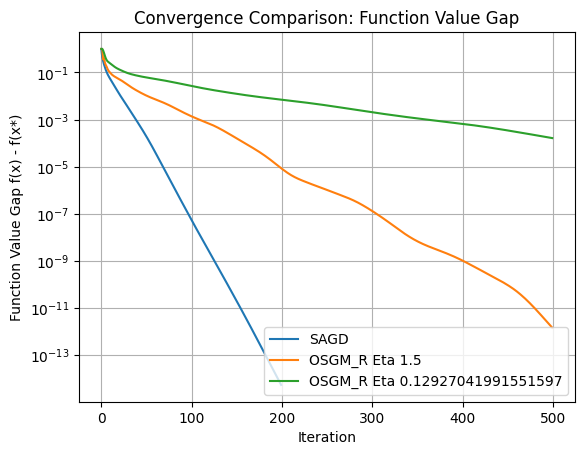

In [30]:
iterations = 500
it = 200
plt.plot(range(it), gap_history_sagd[:it], label='SAGD')

for index, eta in enumerate(eta_candidates_osgm):
    it_local = min(iterations, len(gap_history_osgm_r_all[index]))
    if np.any(np.isnan(gap_history_osgm_r_all[index])):
        continue
    plt.plot(range(it_local), gap_history_osgm_r_all[index][:it_local], label=f'OSGM_R Eta {eta}')
plt.title('Convergence Comparison: Function Value Gap')
plt.xlabel('Iteration')
plt.ylabel('Function Value Gap f(x) - f(x*)')
plt.grid(True)
plt.yscale('log')
plt.legend()
plt.show()